In [15]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import time
import numpy as np
from sys import getsizeof

from cuckoofilter import CuckooFilter
from cuckoofilter import CountingBloomFilter

try:
    import seaborn as sns
    sns.set(context='notebook', style='darkgrid',  font='sans-serif', font_scale=1)
except ImportError: #proceed anyway even if user does not have seaborn. 
    pass

In [98]:
from math import exp, log

cp = 10000 #capacity
finger_print_size = 2 #bytes
b = 4 # 4 buckets
alpha = 0.75

nb = (cp*finger_print_size*b)
bloom_error = exp(-(((nb-1)*log(2))/cp)**2 ) 

cuckoo_error = 1 / (2**( finger_print_size*alpha - log(2*b, 2)))

In [99]:
bloom_error

4.428084647887758e-14

In [89]:
nb

80

In [84]:
2**( finger_print_size*alpha  - log(2*b, 2))

0.08838834764831845

## Insertion

In [2]:
def insert_and_time_filter_cuckoo_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    c_filter = CuckooFilter(capacity, 2)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        try:
            c_filter.insert(str(i))
            num_inserted += 1
        except:
            break
    elapsed_insertion = time.time() - now
    return c_filter, elapsed_insertion

In [3]:
def insert_and_time_filter_bloom_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    b_filter = CountingBloomFilter(capacity)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        b_filter.add(str(i))
    elapsed_insertion = time.time() - now
    return b_filter, elapsed_insertion

In [6]:
item_sizes = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
bloom_times = []
cuckoo_times = []

In [ ]:
for size in item_sizes:
    __,b_time =  insert_and_time_filter_bloom_filter(size)
    bloom_times.append(b_time)
    
    __, c_time = insert_and_time_filter_cuckoo_filter(size)
    cuckoo_times.append(c_time)

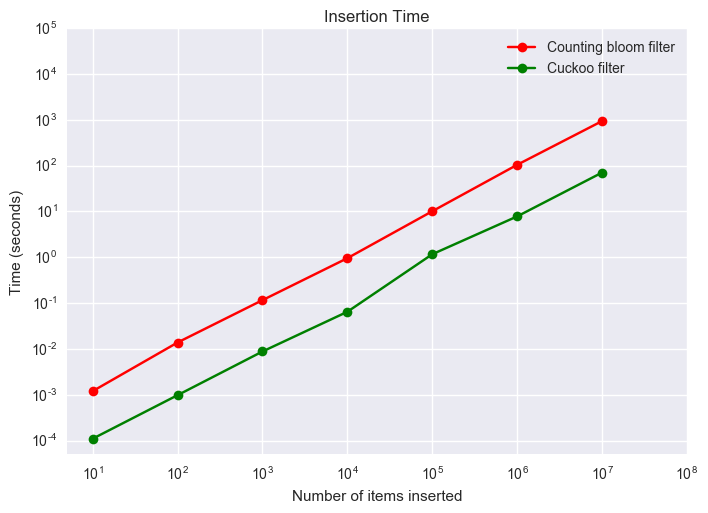

In [7]:
#result from running this once. takes more than 10mins, so not running multiple times. 
bloom_times = [0.0011990070343017578, 0.013823986053466797, 0.11611700057983398,\
               0.9570591449737549, 10.124736070632935, 104.50716304779053, 940.164537191391]
cuckoo_times = [0.00010991096496582031, 0.0009801387786865234, 0.00880289077758789,\
                0.06479001045227051, 1.1676461696624756, 7.817487001419067, 70.73717784881592]
plt.loglog(np.array(item_sizes), np.array(bloom_times), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_times), "-go", ms=7, label="Cuckoo filter")
plt.xlim([5.0 * 10e-1, 10e7])
plt.ylim([5.0 * 10e-6, 10e4])
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items inserted")
plt.title("Insertion Time")
plt.legend()
plt.savefig('images/insertion_time.pdf', bbox_inches='tight')

# Deletion

In [8]:
item_sizes = [10, 100, 1000, 10000, 100000, 1000000]

def delete_from_cuckoo_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    c_filter, _ = insert_and_time_filter_cuckoo_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = c_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        c_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return c_filter, elapsed_time

In [9]:
def delete_from_bloom_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    b_filter, _ = insert_and_time_filter_bloom_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = b_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        b_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return b_filter, elapsed_time

In [10]:
delete_from_cuckoo_filter_and_time(100, percent_to_fill=0.9, percent_delete=1.0)

(<cuckoofilter.cuckoofilter.CuckooFilter at 0x10a2470b8>,
 0.0005440711975097656)

In [11]:
delete_from_bloom_filter_and_time(100, percent_to_fill=0.9, percent_delete=1.0)

(<cuckoofilter.counting_bloom_filter.CountingBloomFilter at 0x10a31af98>,
 0.005234956741333008)

In [12]:
bloom_times_deletion = []
cuckoo_times_deletion = []

In [13]:
for size in item_sizes:
    __,b_time =  delete_from_bloom_filter_and_time(size, percent_to_fill=0.9, percent_delete=1.0)
    bloom_times_deletion.append(b_time)
    
    __, c_time = delete_from_cuckoo_filter_and_time(size, percent_to_fill=0.9, percent_delete=1.0)
    cuckoo_times_deletion.append(c_time)

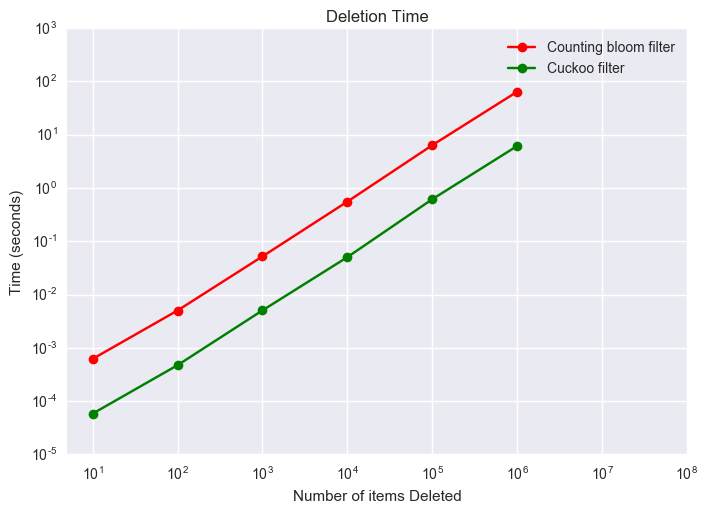

In [14]:
plt.loglog(np.array(item_sizes), np.array(bloom_times_deletion), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_times_deletion), "-go", ms=7, label="Cuckoo filter")
plt.xlim([5.0 * 10e-1, 10e7])
plt.ylim([10e-6, 10e2])
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items Deleted")
plt.title("Deletion Time")
plt.legend()
plt.savefig('images/deletion_time.pdf', bbox_inches='tight')

# Size of the filters

In [1]:
bloom_file_size = []
cuckoo_file_size = []
set_file_size = []

In [7]:
item_sizes = [10, 100, 1000, 10000, 100000, 1000000]
for size in item_sizes:
    b_filter = CountingBloomFilter(size)
    bloom_file_size.append(b_filter.number_of_bytes())
    cuckoo_file_size.append(4*size) #if you use a fingerprint size of 2 bytes
    set_file_size.append(55*size)

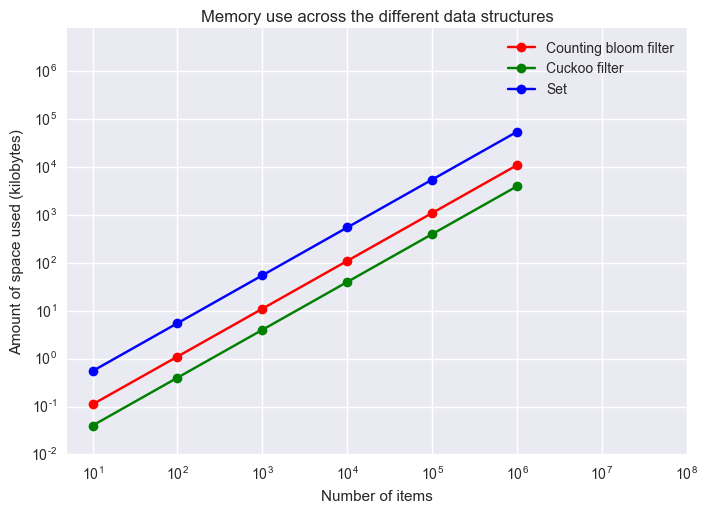

In [11]:
plt.loglog(np.array(item_sizes), np.array(bloom_file_size)/1000, "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_file_size)/1000, "-go", ms=7, label="Cuckoo filter")
plt.loglog(np.array(item_sizes), np.array(set_file_size)/1000, "-bo", ms=7, label="Set")
plt.xlim([5.0 * 10e-1, 10e7])
plt.ylim([10e-3, 0.8*10e6])
plt.ylabel("Amount of space used (kilobytes)")
plt.xlabel("Number of items")
plt.title("Memory use across the different data structures")
plt.legend()
plt.savefig('images/file_size.pdf', bbox_inches='tight')

# False Positives

In [5]:
def false_positive_rate_bloom_and_cuckoo_filter(capacity, percent_to_fill=0.75):
    c_filter, _  = insert_and_time_filter_cuckoo_filter(capacity, percent_fill=percent_to_fill)
    b_filter, _ =  insert_and_time_filter_bloom_filter(capacity, percent_fill=percent_to_fill)
    
    total_queries = 0.0
    false_queries_cuckoo = 0
    false_queries_bloom = 0 
    
    for i in range(capacity+1, 3*capacity):
        if str(i) in c_filter:
            false_queries_cuckoo += 1
        
        if str(i) in b_filter:
            false_queries_bloom += 1
        
        total_queries = total_queries + 1
    
    
    return false_queries_cuckoo/total_queries , false_queries_bloom/total_queries
    

In [30]:
false_positive_rate_bloom_and_cuckoo_filter(int(3e3), percent_to_fill=0.8)

(0.0, 0.0013335555925987664)

In [6]:
bloom_fp = []
cuckoo_fp = []
#item_sizes = [50000, 100000, 500000, 1000000, 1500000, 10000000]
#item_sizes = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]

item_sizes = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7]

for size in item_sizes:
    cfp, bfp = false_positive_rate_bloom_and_cuckoo_filter(int(size),\
                                            percent_to_fill=0.75)
    bloom_fp.append(bfp)
    cuckoo_fp.append(cfp)
    print(size)


1000.0
3000.0
10000.0
30000.0
100000.0
300000.0
1000000.0
3000000.0
10000000.0
30000000.0


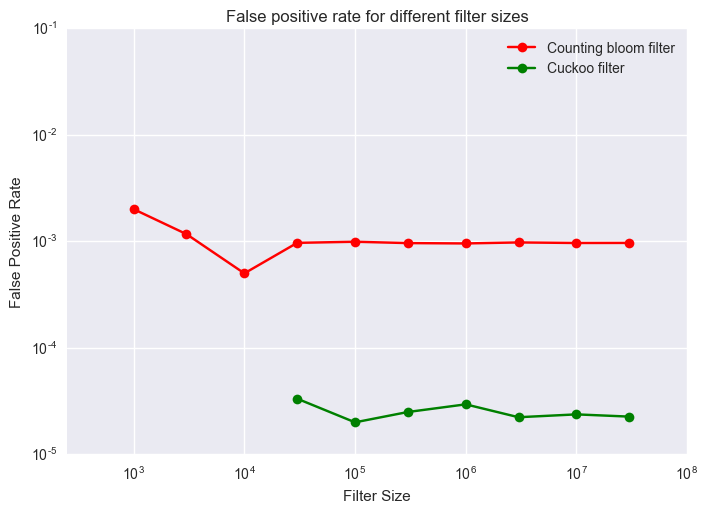

In [14]:
#result from running this once. takes more than 10mins, so not running multiple times. 
plt.loglog(np.array(item_sizes), np.array(bloom_fp), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_fp), "-go", ms=7, label="Cuckoo filter")
plt.xlim([2.5*10e1, 10e7])
plt.ylim([10e-6, 10e-2])
plt.ylabel("False Positive Rate")
plt.xlabel("Filter Size")
plt.title("False positive rate for different filter sizes")
plt.legend()
plt.savefig('images/false_positive.png', bbox_inches='tight')